<a href="https://colab.research.google.com/github/JiUUoong/CODE/blob/main/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep Q-Network (DQN)
# Q table을 Q network로 대체
# 샘플 효율 -> replay buffer
# 학습 안정성 -> target network

In [ ]:
import gym
# https://gymnasium.farama.org/
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque # replay buffer (s, a, r, s')
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
env = gym.make("CartPole-v1")

# 그래프 실시간으로 노트북 상에서 업데이트되도록
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display
plt.ion()   # interactive ON

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# replay buffer 만들기
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

# 저장소
class ReplayMemory(object):
  def __init__(self, capacity): # buffer의 저장공간 사이즈
    self.memory = deque([], maxlen=capacity)
    return
  def push(self, *args): # 버퍼에 저장한다 *args 여러 인자가 (튜플/리스트)로 들어올 수 있음
    # model(**encoded_input) # 여러 인자가 사전 형태로 들어올 수 있음
    self.memory.append(Transition(*args))
    return
  def sample(self, batch_size): # 버퍼에서 batch_size개의 샘플들 꺼내기
    return random.sample(self.memory, batch_size)
  def __len__(self): # 버퍼 얼마나 차있는지
    return len(self.memory)

In [ ]:
def my_addition(*args):
  mysum = 0
  for a in args:
    mysum += a
  return mysum
array = [1, 2, 3]
# my_addition(a=array[0], b=array[1], c=array[2])
my_addition(*array)

In [ ]:
# DQN을 nn.Module 상속
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()   # 피상속(부모) 클래스를 초기화해야 밑에 다른 nn.xxx 추가할 수 있음
    # 모델 만들기 # 2개 또는 3개 층 추천
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)
    #
    #
    return
  def forward(self, state):
    # 이 DQN은 상태 정보를 입력으로 받아서
    # 행동 선택지 개수를 폭으로 가지는 배열을 반환함
    # 만든 모델에 x 통과시키기
    hidden = F.relu(self.layer1(state))
    hidden = F.relu(self.layer2(hidden))

    return self.layer3(hidden)

In [ ]:
# 튜닝 하이퍼파라미터 (코랩 노트북 처음 작성시 적어넣은 값들)
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.8
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001       # 본체 네트워크의 얼만큼을 타겟 네트워크에 카피할 건지
LR = 2e-5

In [ ]:
# 좀 괜찮은 성능 내는 값
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005       # 본체 네트워크의 얼만큼을 타겟 네트워크에 카피할 건지
LR = 1e-4

In [ ]:
n_actions = env.action_space.n
seed = 42
state = env.reset(seed=seed) # 환경 초기화
random.seed(seed)
torch.manual_seed(seed)
n_observations = len(state)

In [ ]:
# 본체 네트워크, 타겟 네트워크
# 81번 슬라이드
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())     # 본체 네트워크의 파라미터를 타겟 네트워크로 카피
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

In [ ]:
# action 선택기 함수
def select_action(state):
  global steps_done       # 전체 트레이닝 루프에서 지금 몇번째 스텝 학습 중?
  sample = random.random()      # 0에서 1 사이 난수
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
  steps_done += 1

  if sample > eps_threshold:      # greedy action selection (exploitation)
    with torch.no_grad():         # 학습 안 함
      return policy_net(state).max(1)[1].view(1, 1) # action 선택지 중 가장 높은 행동가치 주는 그 액션
      # policy_net(state)의 출력은 텐서 (폭이 n_actions)
      # max라는 함수가 1을 인자로 -> 가장 큰 1개만 반환
      # [1] max의 반환 값은 튜플 (제일 큰 값, 그 값의 위치) -> 그 값의 위치 (즉 어떤 액션)
      # view(1, 1)는 텐서 reshape
  else:                           # random action selection (exploration)
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
      # env.action_space -> 환경 상에서 정의되어있는 행동 선택지
      # .sample() -> 그 중 무작위 행동 하나 선택
      # 안쪽 [], 바깥쪽 [] -> batch 단위로 텐서 만들기 위함
      # device=device -> 텐서이름.to(device)
      # dtype 자료형이 파이토치 상에서 정의되어있는 long integer

In [ ]:
episode_durations = []
# 각 에피소드의 길이를 저장할 리스트
# 이 리스트의 값을 기준으로 그래프 그리기
# 함수 여기 붙여넣기

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
from time import sleep

for i in range(20):
  episode_durations.append(i**2)
  sleep(1)
  plot_durations()

<Figure size 640x480 with 0 Axes>

In [ ]:
a = [1,2, 3]
b = [4, 5, 6]
list(zip(a, b))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 4), (2, 5), (3, 6)]

In [ ]:
a = "abc"
# subscriptable 가능한 자료형
# 순회할 수 있는 자료형 -> iterate할 수 있는 iterable
# list, tuple, string, numpy array, tensor, pandas dataframe
# 안 되는 자료형: dict, set, int, float
mydict = {"A":1, "B": 2}
mytuple = (0,4, 5) # 바꿀 수 없음 immutable

KeyError: ignored

In [ ]:
# 학습
def optimize_model():
  # 버퍼에서 batch_size개만큼의 (s,a,r,s') 꺼내서 학습하기

  # 버퍼가 batch_size보다 작다면
  if len(memory) < BATCH_SIZE:
    return

  ################ 버퍼에서 (s, a, r, s')꺼내기
  # experience replay (과거 경험 샘플들로 학습하기)
  # 과거 언젠가의 s에 놓여있을 때 a행동을 실행했더니 r보상을 얻으며 s'로 이동했다
  # 라는 사실이 주어졌을 때 모델의 가치 함수가 어떻게 업데이트되어야할까 -> optimize_model
  transitions = memory.sample(BATCH_SIZE) # (s, a, r, s'), (s, a, r, s'), ....
  batch = Transition(*zip(*transitions)) # namedtuple이라는 이름의 자료형
  # Transition은 "state", "action", "next_state", "reward"
  # zip은 state끼리, action끼리, ㅇㅇㅇ끼리 모았다
  # (s, s, s, s, s, ....s), (a, a, ..., a), (r, r,...,r) (s', s', s', ..., s')

  # final(terminal) state인지 구분
  # "48번 슬라이드에서 Q(terminal_state, a)는 0으로 둔다"를 처리하기 위한 코드
  ################################################
  # 지금 terminal state라면, next_state를 None으로 두고, reward를 0으로
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
  # lambda 는 익명함수 s를 인자로 받아서 튜플을 반환
  # 튜플의 0번째 원소는 s가 None인지 판단 후, None이면 False, None이 아니면 True
  # 튜플의 1번째 원소는 next_state
  # map() s는 인자의 이름이고 어떤 값이 들어가느냐? -> next_state가 들어감
  # map의 역할은 한 함수를 여러 값에 적용하기
  # 한 함수 (람다); 여러 값은 batch.next_state -> (128, 4)
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
  # batch.next_state의 일부임
  # 일부를 어떻게 고를까 기준이 s가 None인지 여부
  ################################################

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  # 행동가치 Q(s,a)
  state_action_values = policy_net(state_batch).gather(1, action_batch)
  next_state_values = torch.zeros(BATCH_SIZE, device=device) # 값이 0으로 채워져있는 텐서
  # "48번 슬라이드에서 Q(terminal_state, a)는 0으로 둔다"를 처리하기 위한 코드
  with torch.no_grad(): # 학습 안 함 (기울기 계산 안 함)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # 여기까지 진행하고, next_state_values라는 텐서를 보면,
    # 일부는 0이고, 일부는 아님 -> terminal_state라고 하면 그에 해당하는 칸에는 0이 있고,
    # terminal_state가 아니라면, 거기에는 max_a target_net (s') 값이 있을 거임
    # final state가 아닌 경우에는 행동가치를 target 네트워크에게 물어보기
    # 74번 슬라이드 쎄타_
    # next_state_values는 일단 전부 0으로 채워짐
    # 이 중, terminal state가 아닌 (즉, 에피소드가 이후 더 진행될 수 있는 경우) 칸만 target_net 출력값으로 갱신되고,
    # 나머지 (즉, 에피소드가 끝나는 시점의 state (next_state==None))는 0인 채로 남아있음
    # max(1)은 텐서를 1개 반환함
    # 튜플의 0번째 원소는 가장 큰 값; 튜플의 1번째 원소는 그 값의 위치
  td_target = reward_batch + GAMMA * next_state_values
  # td_target = r + gamma * max_a target_net(s', a)
  # td_error의 제곱의 평균이 DQN 손실
  loss_fn = nn.SmoothL1Loss()
  # 파이토치에 구현되어 있는 손실함수 리스트: https://pytorch.org/docs/stable/nn.html#loss-functions
  # 강화학습에서 Huber, SmoothL1이 많이 쓰임; 슬라이드 내용 그대로 구현? -> MSELoss
  loss = loss_fn(state_action_values, td_target)
  # state_action_values는 슬라이드 상에서 Q(s, a) -> 즉 모델 판단하기에 s, a 쌍의 가치
  # td_target은 슬라이드 상에서 r + gamma * max_a Q(s', a) -> 한 스텝 경험해봤을 때 실제 수집된 보상

  optimizer.zero_grad()
  loss.backward() # 역전파
  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  # gradient clipping; 최대 100이란 값만 가지도록
  optimizer.step()
  return


In [ ]:
# 트레이닝 루프
# GPU 있는지 여부에 따라 에피소드 개수 달리
if torch.cuda.is_available():
  num_episodes = 600
else:
  num_episodes = 50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
episode_durations = list()

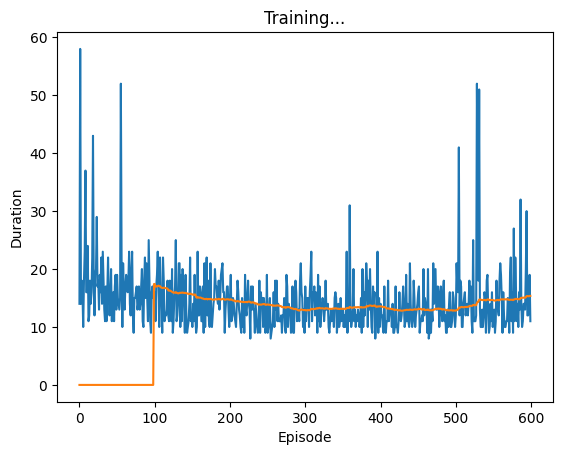

<Figure size 640x480 with 0 Axes>

In [ ]:
# 에피소드마다
# 스텝마다
episode_durations = list()
steps_done = 0
for ep in range(num_episodes):
  state = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  # unsqueeze는 축을 추가
  for t in count():
    # behavior policy에 따라 액션 고르기
    action = select_action(state) # epsilon-greedy대로 액션 골라짐 48번 슬라이드 4번째 줄
    # "Choose A from S..."
    # 고른 액션으로 환경과 1스텝 상호작용
    observation, reward, terminated, truncated = env.step(action.item())
    # 48번 슬라이드 5번째 줄 ("Take action,...")
    # 텐서이름.item() -> 내용물(값)
    reward = torch.tensor([reward], device=device)
    # unsqueeze 안 하고, 대신 리스트로 [reward] 이렇게 줘도 됨 -> (1, reward_갯수) shape를 가짐

    if terminated:
      next_state = None
      # 막대가 쓰러지거나 카트가 너무 멀리 움직였으면 다음상태를 None으로 두기
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
      # 그게 아니라면 다음상태(observation)을 텐서로 바꾸기

    # 버퍼에 저장 (s, a, s', r)
    memory.push(state, action, next_state, reward)

    state = next_state
    optimize_model()

    # target network 관리 방법 2가지
    # 1. 슬라이드 내용처럼 주기를 활용한 업데이트
    # 주기 변수 예를 들여 copy_every = 1000
    # if global_step % copy_every == 0:
    #   target_net.load_state_dict(policy_net.state_dict())
    # 2. 밑에 코드 내용처럼 매 step, TAU만큼 미세하기 카피해가는 방법
    # target network를 TAU만큼 (천천히) 카피하다
    target_net_params = target_net.state_dict() # target net 파라미터 값 (쎄타-)
    policy_net_params = policy_net.state_dict() # 본체 네트워크 파라미터 값 (쎄타)
    for key in policy_net_params: # 본체 값은 하나씩 보면서
      target_net_params[key] = TAU*policy_net_params[key] + (1-TAU)*target_net_params[key]
      # TAU만큼 반영한다
      # 본체, 타겟 파라미터 값들을 가중평균 매기는 중
      # 가중치는 본체:타겟이 TAU:(1-TAU)
    target_net.load_state_dict(target_net_params)

    done = terminated or truncated
    if done:
      episode_durations.append(t + 1)
      plot_durations()
      break # 지금 에피소드 끝내고 새 에피소드 시작



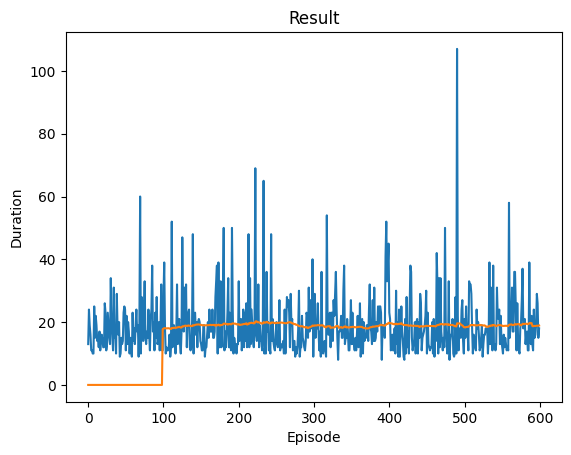

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_durations(show_result=True)
plt.ioff() # interactive OFF
plt.show()

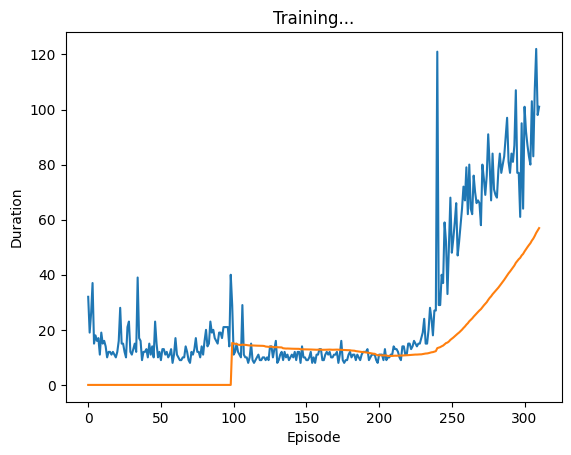

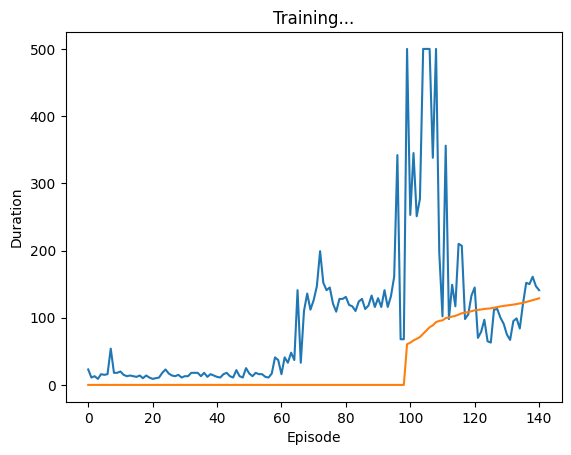

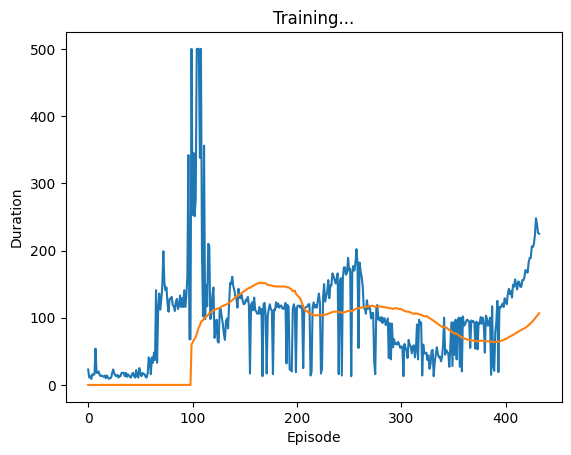

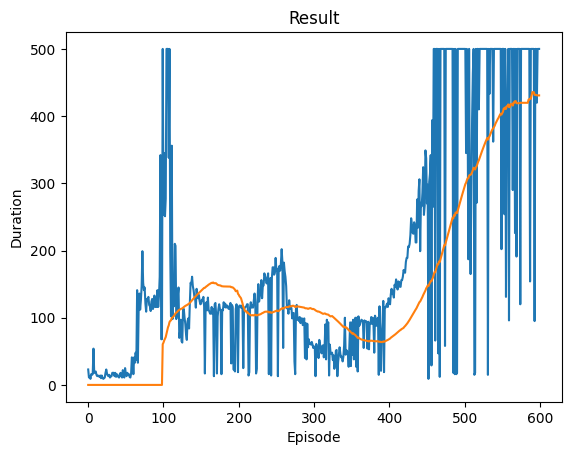

In [ ]:
# 강화학습, 상태, 행동, 가치함수, 정책, 보상

# 강화학습
# 순차적 의사 결정 (sequential decision-making)
# MDP로 모델링할 수 있는 문제
# MDP를 알아야만 풀 수 있는 문제는 아님
# 에이전트 여럿인 경우도 생각해볼 수 있음 (multi-agent RL)

# 가치 함수
# 상태 또는 행동의 가치(좋음)을 가늠하는 도구
# 최적의 가치 함수을 안다 = 최적의 정책을 찾음
# 최적의 가치 함수 최적의 평균 보상이 주어짐을 의미함
# 에이전트가 여럿이면 가치 함수는 어떻게 영향을 받을까?

# 정책
# 정책은 분포다 정책은 함수다 -> 분포(함수)면 분포 추정기를 쓸 수 있으니까
# 신경망을 추정기(approximator / estimator)로 쓸 수 있으니까
# 정책이 좋다/나쁘다 장기적으로 높은 평균 보상
# MDP를 안다 p(s', r | s, a) -> 최적 정책 구하기 쉬움
# 각각의 평균 보상으로 여러 정책 비교 분석이 가능함

# 보상
# 보상은 항상 환경에 주어지는 건 아님; 모델 설계자의 선택
# 보상은 0일 수 있습니다
# 보상과 소요시간의 관계: 시간이 흐름에 따라 음수의 보상
# 보상 설계 성능에 큰 영향

# 상태
# 차원의 저주: feature의 갯수가 많아도 모델 성능이 꼭 오르진 않음
# 상태 단순화 예를 들면 컬러->흑백; 차원 축소
# 특정 상태에서 특정 행동을 실행하면 다음 상태는 확정적이지 않을 수 있음
# 어드밴티지 = 행동 가치 - 상태 가치
# 상태 변화는 행동의 변화에 영향을 반드시 받는다? 아님